In [1]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("mlg-ulb/creditcardfraud")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/creditcardfraud


In [2]:
import sys
!{sys.executable} -m pip install --upgrade --no-deps scikit-learn imbalanced-learn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.5/13.5 MB 89.3 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.2.2
    Uninstalling scikit-learn-1.2.2:
      Successfully uninstalled scikit-learn-1.2.2


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import StratifiedKFold, GridSearchCV, cross_val_score
from sklearn.preprocessing import RobustScaler, PowerTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score, f1_score, precision_score, recall_score, classification_report
from imblearn.over_sampling import SMOTE, ADASYN
from imblearn.pipeline import Pipeline as ImbPipeline
from scipy import stats
import warnings
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, BaggingClassifier
from catboost import CatBoostClassifier
warnings.filterwarnings('ignore')

# Set plotting style
plt.style.use('default')
sns.set_palette("husl")

In [4]:
# Load the dataset
df = pd.read_csv('/kaggle/input/creditcardfraud/creditcard.csv')

print("="*60)
print("CREDIT CARD FRAUD DATASET ANALYSIS")
print("="*60)

CREDIT CARD FRAUD DATASET ANALYSIS


In [5]:
# 1. BASIC DATASET INFORMATION
print("\n1. DATASET OVERVIEW")
print("-" * 30)
print(f"Dataset Shape: {df.shape}")
print(f"Total Records: {df.shape[0]:,}")
print(f"Total Features: {df.shape[1]}")

print("\n2. COLUMN NAMES AND DATA TYPES")
print("-" * 30)
print(df.dtypes)

print("\n3. BASIC STATISTICS")
print("-" * 30)
print(df.describe())


1. DATASET OVERVIEW
------------------------------
Dataset Shape: (284807, 31)
Total Records: 284,807
Total Features: 31

2. COLUMN NAMES AND DATA TYPES
------------------------------
Time      float64
V1        float64
V2        float64
V3        float64
V4        float64
V5        float64
V6        float64
V7        float64
V8        float64
V9        float64
V10       float64
V11       float64
V12       float64
V13       float64
V14       float64
V15       float64
V16       float64
V17       float64
V18       float64
V19       float64
V20       float64
V21       float64
V22       float64
V23       float64
V24       float64
V25       float64
V26       float64
V27       float64
V28       float64
Amount    float64
Class       int64
dtype: object

3. BASIC STATISTICS
------------------------------
                Time            V1            V2            V3            V4  \
count  284807.000000  2.848070e+05  2.848070e+05  2.848070e+05  2.848070e+05   
mean    94813.859575  1.175161e

In [6]:
# 2. MISSING VALUES ANALYSIS
print("\n4. MISSING VALUES ANALYSIS")
print("-" * 30)
missing_values = df.isnull().sum()
missing_percentage = (missing_values / len(df)) * 100

missing_df = pd.DataFrame({
    'Missing Count': missing_values,
    'Missing Percentage': missing_percentage
})

print(missing_df[missing_df['Missing Count'] > 0])
if missing_df['Missing Count'].sum() == 0:
    print("✓ No missing values found in the dataset!")


4. MISSING VALUES ANALYSIS
------------------------------
Empty DataFrame
Columns: [Missing Count, Missing Percentage]
Index: []
✓ No missing values found in the dataset!


CLASS DISTRIBUTION
------------------------------
Class Distribution:
Class 0: 284,315 (99.83%)
Class 1: 492 (0.17%)


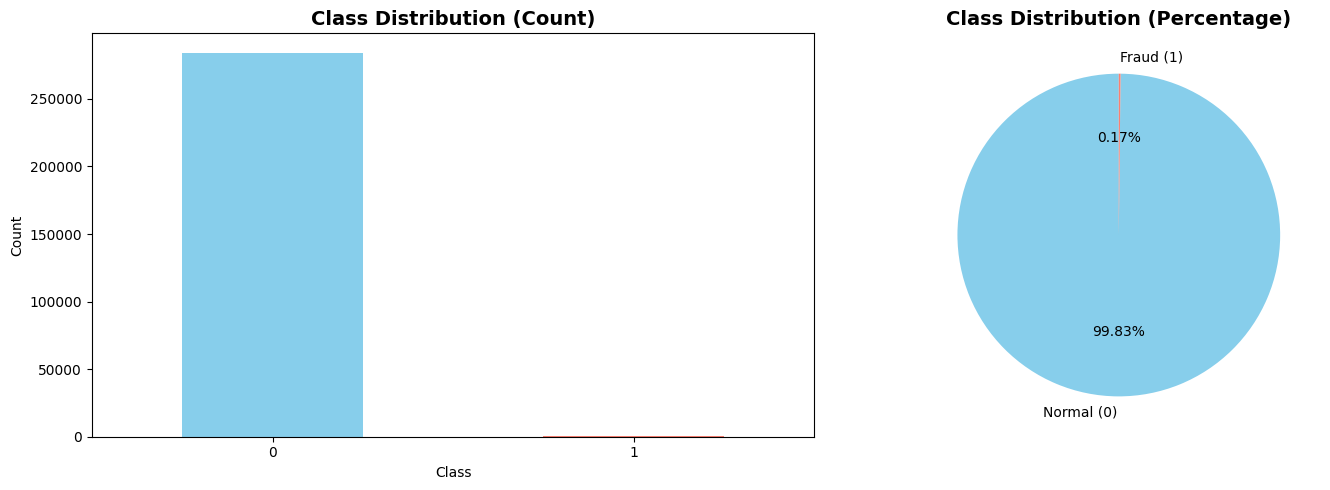

In [7]:
# 3. CLASS DISTRIBUTION
print("CLASS DISTRIBUTION")
print("-" * 30)
class_dist = df['Class'].value_counts()
class_percent = df['Class'].value_counts(normalize=True) * 100

print("Class Distribution:")
for class_val in [0, 1]:
    print(f"Class {class_val}: {class_dist[class_val]:,} ({class_percent[class_val]:.2f}%)")

# Visualization: Class Distribution
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Bar plot
class_dist.plot(kind='bar', ax=ax1, color=['skyblue', 'salmon'])
ax1.set_title('Class Distribution (Count)', fontsize=14, fontweight='bold')
ax1.set_xlabel('Class')
ax1.set_ylabel('Count')
ax1.tick_params(axis='x', rotation=0)

# Pie chart
ax2.pie(class_dist.values, labels=['Normal (0)', 'Fraud (1)'], autopct='%1.2f%%', 
        colors=['skyblue', 'salmon'], startangle=90)
ax2.set_title('Class Distribution (Percentage)', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

AMOUNT ANALYSIS BY CLASS
------------------------------
Amount Statistics by Class:
          count        mean         std  min   25%    50%     75%       max
Class                                                                      
0      284315.0   88.291022  250.105092  0.0  5.65  22.00   77.05  25691.16
1         492.0  122.211321  256.683288  0.0  1.00   9.25  105.89   2125.87


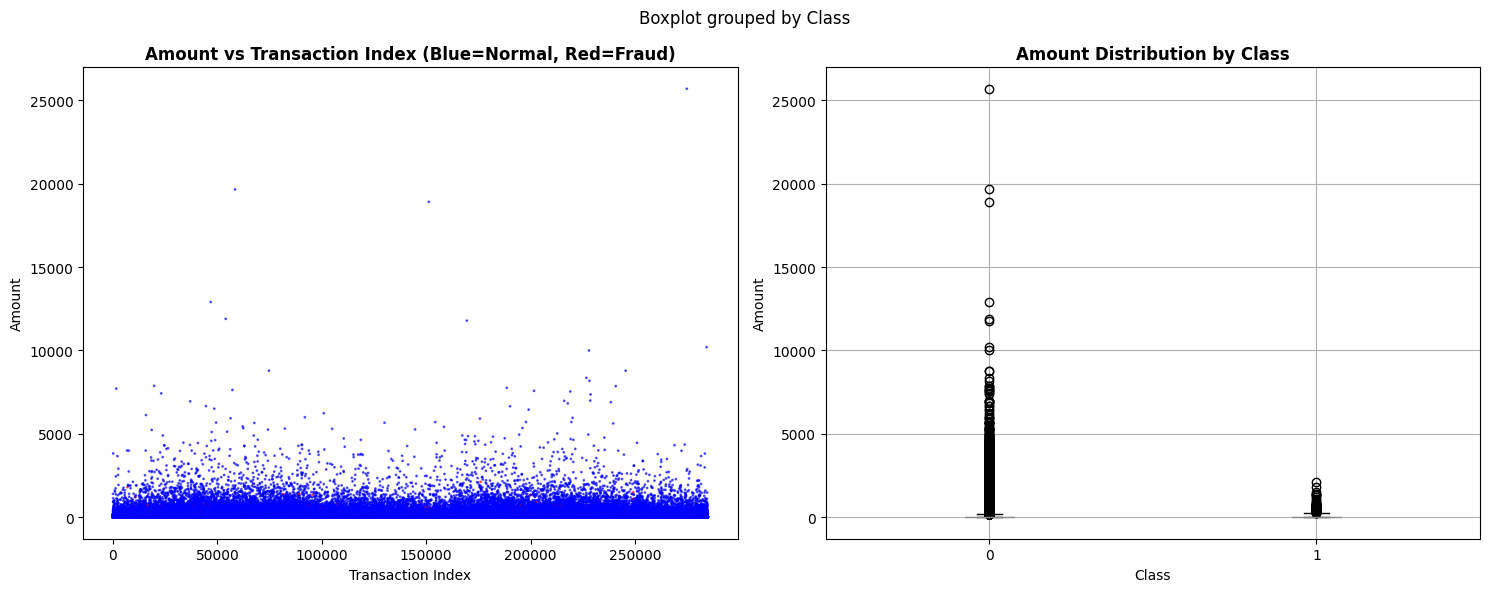

In [8]:
# 4. AMOUNT VS CLASS SCATTER PLOT
print("AMOUNT ANALYSIS BY CLASS")
print("-" * 30)

# Amount statistics by class
print("Amount Statistics by Class:")
amount_stats = df.groupby('Class')['Amount'].describe()
print(amount_stats)

# Scatter plot and box plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Scatter plot
colors = ['blue' if x == 0 else 'red' for x in df['Class']]
ax1.scatter(df.index, df['Amount'], c=colors, alpha=0.6, s=1)
ax1.set_title('Amount vs Transaction Index (Blue=Normal, Red=Fraud)', fontsize=12, fontweight='bold')
ax1.set_xlabel('Transaction Index')
ax1.set_ylabel('Amount')

# Box plot
df.boxplot(column='Amount', by='Class', ax=ax2)
ax2.set_title('Amount Distribution by Class', fontsize=12, fontweight='bold')
ax2.set_xlabel('Class')
ax2.set_ylabel('Amount')

plt.tight_layout()
plt.show()

CORRELATION ANALYSIS
------------------------------
Correlation matrix heatmap saved as 'correlation_matrix_heatmap.png'


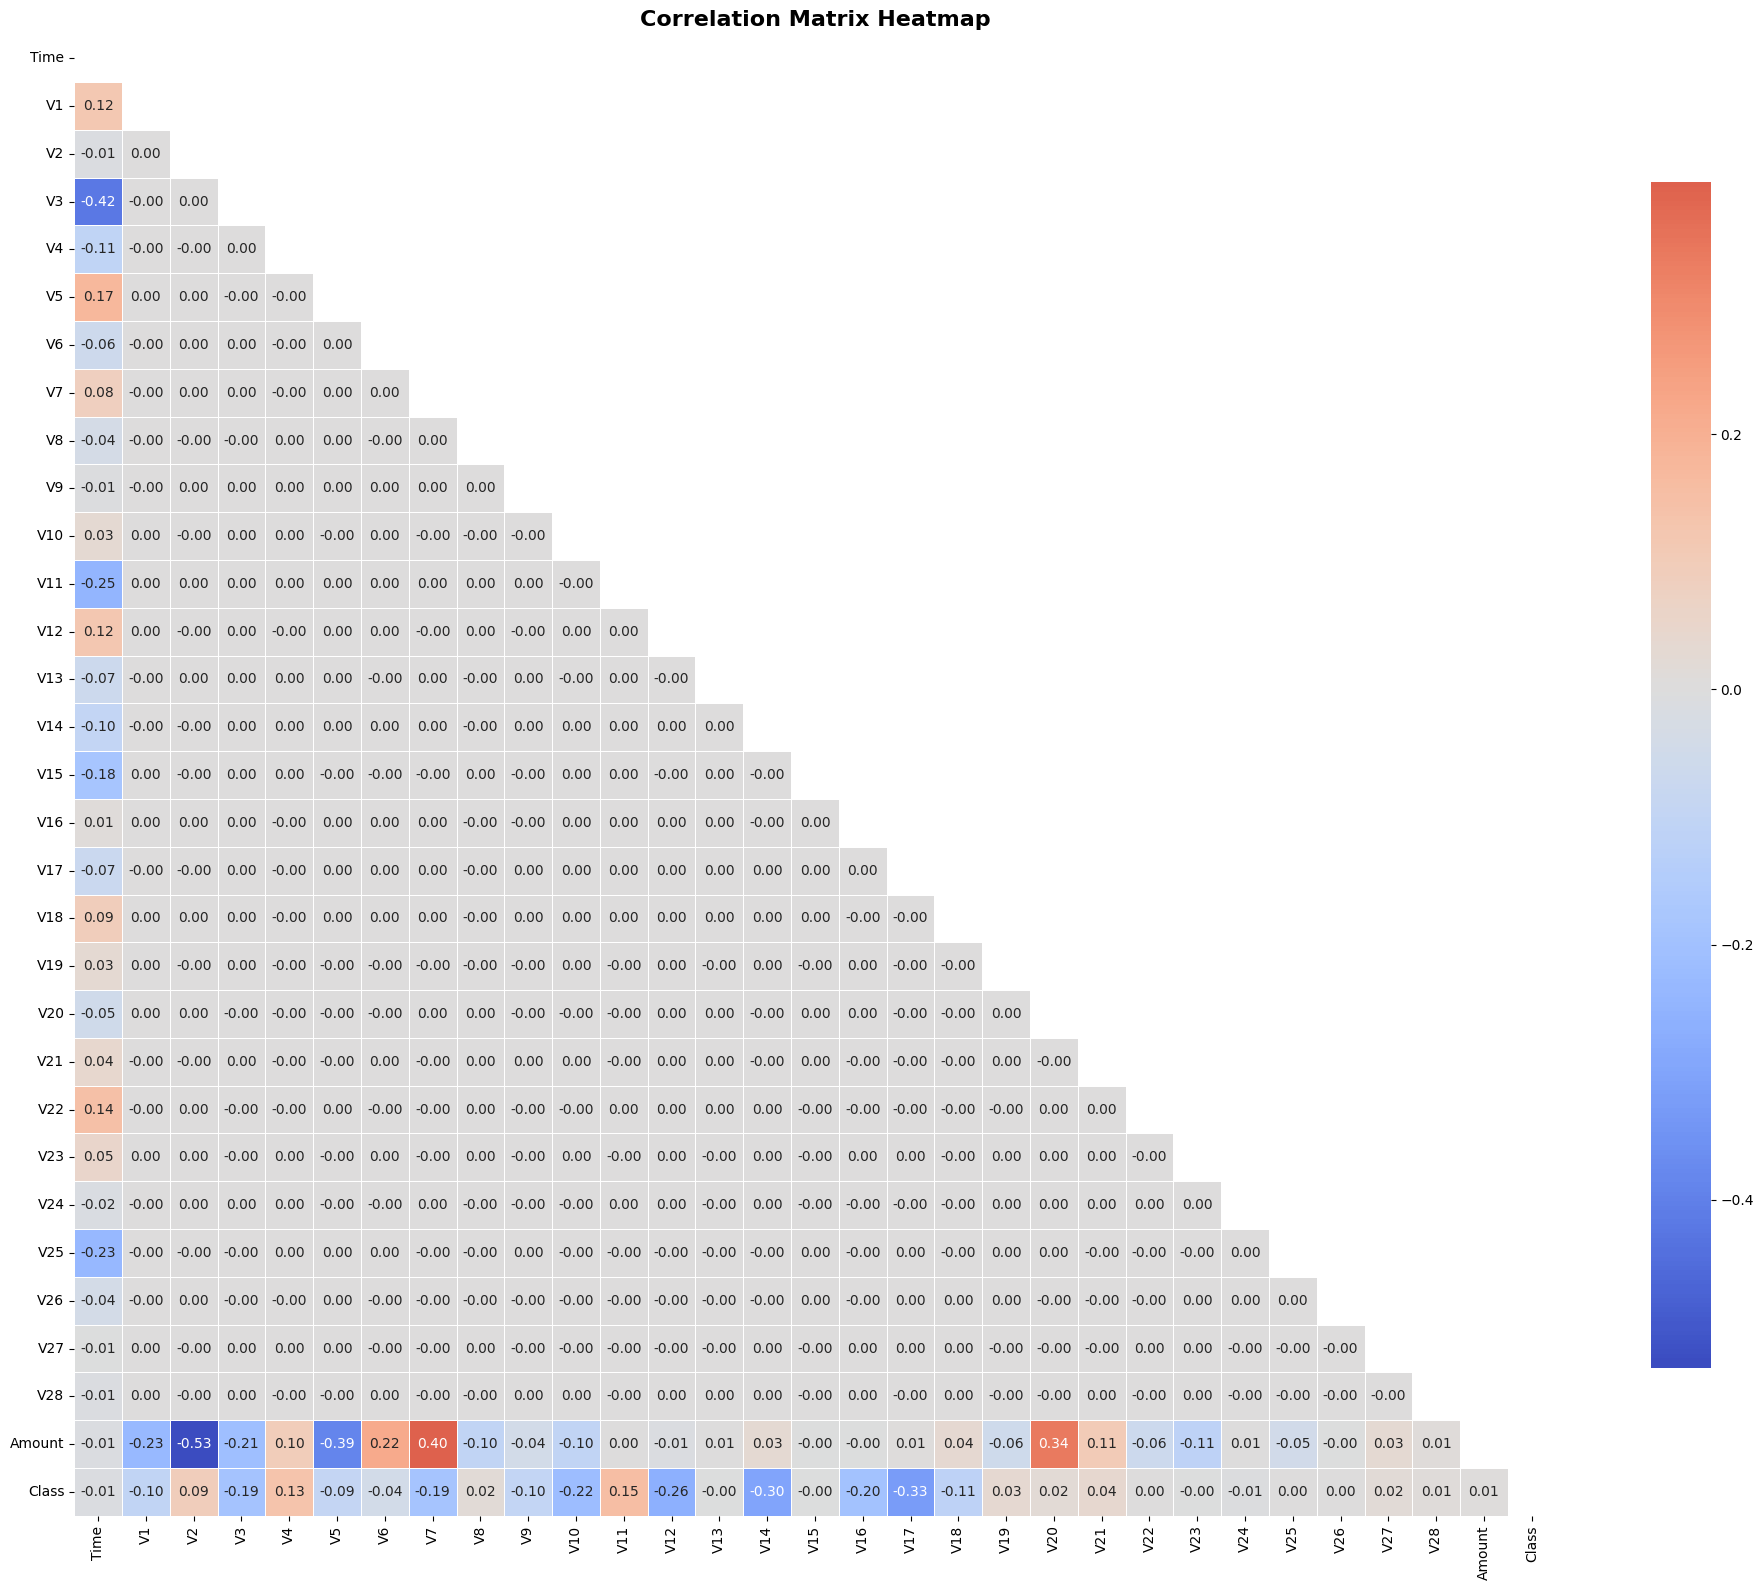

Top correlations with Class (Fraud):
V17    0.326481
V14    0.302544
V12    0.260593
V10    0.216883
V16    0.196539
V3     0.192961
V7     0.187257
V11    0.154876
V4     0.133447
V18    0.111485
Name: Class, dtype: float64


In [9]:
# 5. CORRELATION MATRIX HEATMAP
print("CORRELATION ANALYSIS")
print("-" * 30)

# Calculate correlation matrix
correlation_matrix = df.corr()

# Plot heatmap
plt.figure(figsize=(20, 16))
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))
sns.heatmap(correlation_matrix, mask=mask, annot=True, cmap='coolwarm', center=0,
            square=True, linewidths=0.5, cbar_kws={"shrink": .8}, fmt='.2f')
plt.title('Correlation Matrix Heatmap', fontsize=16, fontweight='bold')
plt.tight_layout()

# Save the figure as PNG
plt.savefig('correlation_matrix_heatmap.png', dpi=300, bbox_inches='tight')
print("Correlation matrix heatmap saved as 'correlation_matrix_heatmap.png'")

plt.show()


# Top correlations with Class
print("Top correlations with Class (Fraud):")
class_corr = correlation_matrix['Class'].abs().sort_values(ascending=False)
print(class_corr[1:11])  # Top 10 excluding Class itself

FEATURE DISTRIBUTIONS BY CLASS
------------------------------
Graph saved as 'feature_distributions_kde.png'


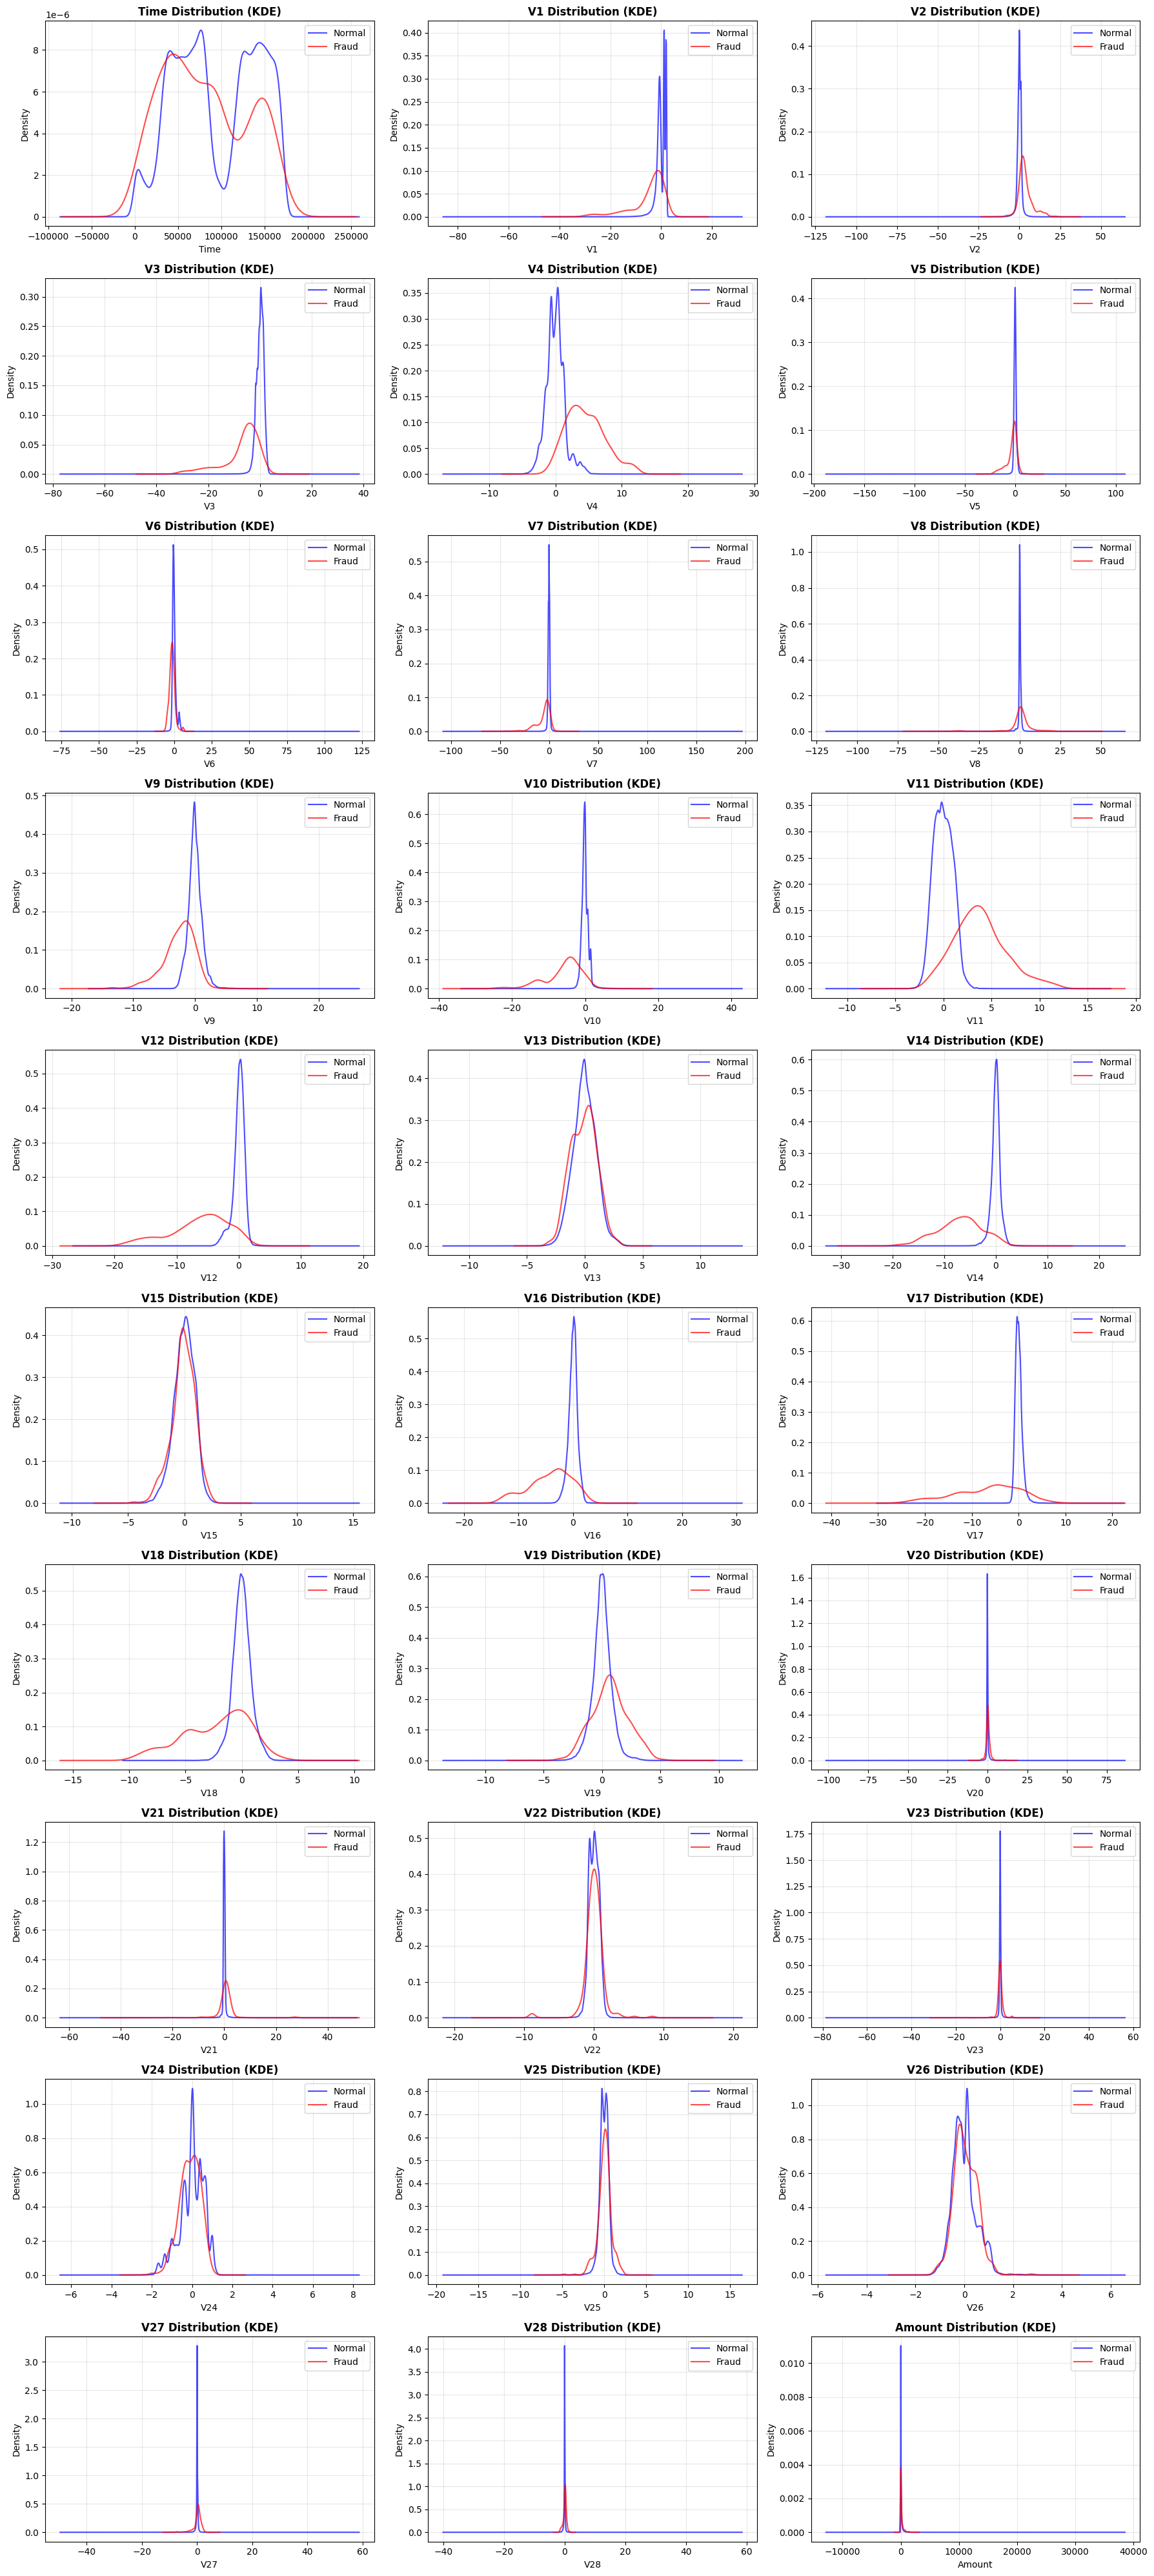

In [10]:
# 6. FEATURE DISTRIBUTIONS BY CLASS (KDE/Density Plots)
print("FEATURE DISTRIBUTIONS BY CLASS")
print("-" * 30)

# Plot distributions for key features using KDE (density plots)
features_to_plot = df.columns

fig, axes = plt.subplots(10, 3, figsize=(18, 40))
axes = axes.ravel()

for i, feature in enumerate(features_to_plot):
    if i < len(axes):
        # Create KDE/density plots for both classes
        df[df['Class'] == 0][feature].plot.density(ax=axes[i], alpha=0.7, label='Normal', color='blue')
        df[df['Class'] == 1][feature].plot.density(ax=axes[i], alpha=0.7, label='Fraud', color='red')
        
        axes[i].set_title(f'{feature} Distribution (KDE)', fontweight='bold')
        axes[i].legend()
        axes[i].set_xlabel(feature)
        axes[i].set_ylabel('Density')
        axes[i].grid(True, alpha=0.3)

# Remove empty subplots
for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()

# Save the plot as PNG
plt.savefig('feature_distributions_kde.png', dpi=300, bbox_inches='tight')
print("Graph saved as 'feature_distributions_kde.png'")

plt.show()

SKEWNESS ANALYSIS
------------------------------
Skewness Analysis (sorted by absolute skewness):
Feature  Skewness    Interpretation
  Class 23.997453     Highly Skewed
 Amount 16.977635     Highly Skewed
    V28 11.192032     Highly Skewed
     V8 -8.521899     Highly Skewed
    V23 -5.875109     Highly Skewed
     V2 -4.624841     Highly Skewed
    V17 -3.844894     Highly Skewed
    V21  3.592972     Highly Skewed
     V1 -3.280650     Highly Skewed
     V7  2.553894     Highly Skewed
     V5 -2.425889     Highly Skewed
    V12 -2.278389     Highly Skewed
     V3 -2.240144     Highly Skewed
    V20 -2.037145     Highly Skewed
    V14 -1.995165     Highly Skewed
     V6  1.826571     Highly Skewed
    V10  1.187134     Highly Skewed
    V27 -1.170203     Highly Skewed
    V16 -1.100960     Highly Skewed
     V4  0.676289 Moderately Skewed
    V26  0.576690 Moderately Skewed
     V9  0.554677 Moderately Skewed
    V24 -0.552496 Moderately Skewed
    V25 -0.415790            Normal
  

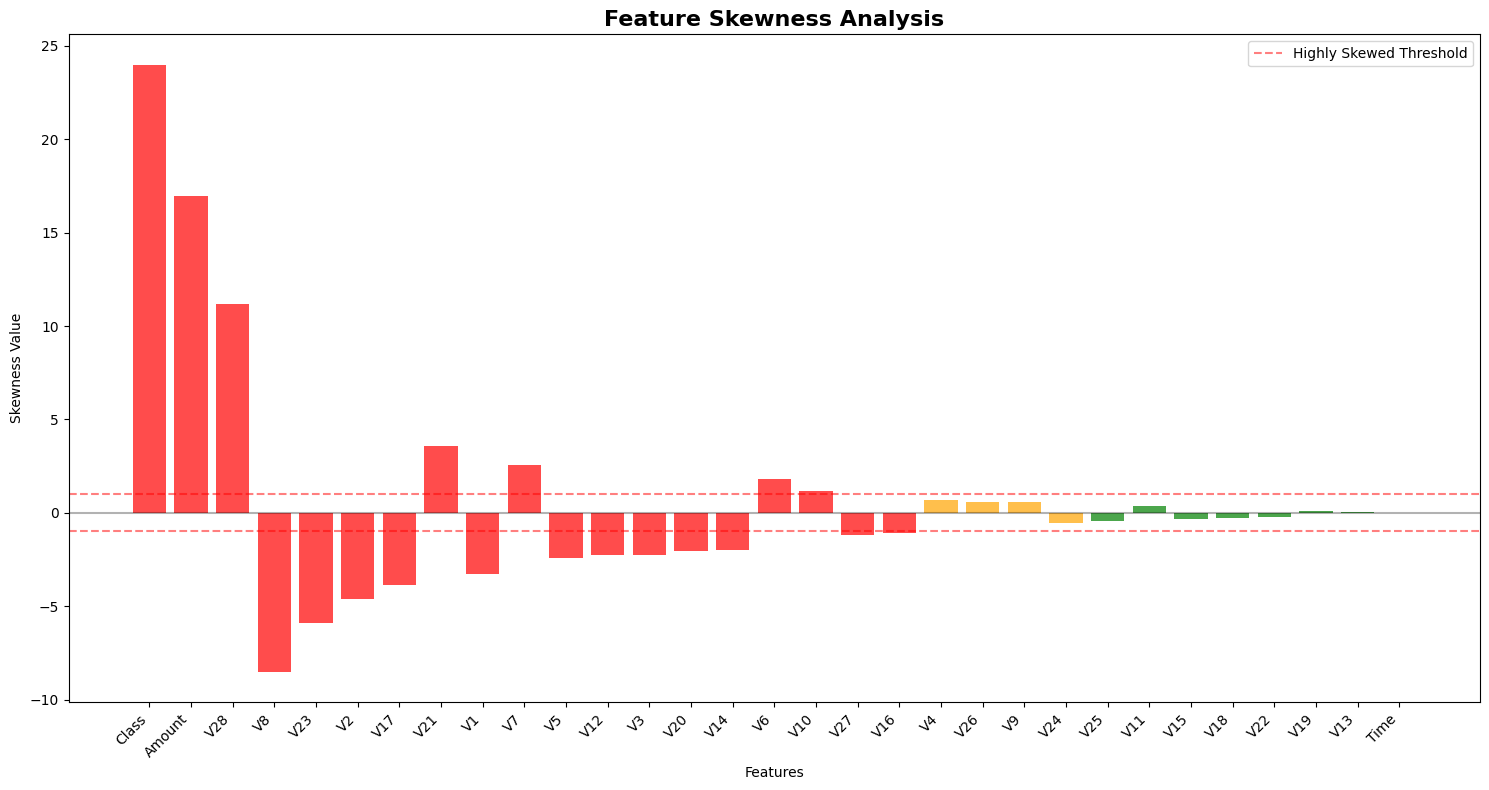

In [11]:
# 7. SKEWNESS ANALYSIS
print("SKEWNESS ANALYSIS")
print("-" * 30)

# Calculate skewness for all numeric features
skewness_data = []
for column in df.select_dtypes(include=[np.number]).columns:
    skew_val = stats.skew(df[column].dropna())
    skewness_data.append({
        'Feature': column,
        'Skewness': skew_val,
        'Interpretation': 'Highly Skewed' if abs(skew_val) > 1 else 
                        'Moderately Skewed' if abs(skew_val) > 0.5 else 'Normal'
    })

skewness_df = pd.DataFrame(skewness_data)
skewness_df = skewness_df.sort_values('Skewness', key=abs, ascending=False)

print("Skewness Analysis (sorted by absolute skewness):")
print(skewness_df.to_string(index=False))

# Visualize skewness
plt.figure(figsize=(15, 8))
colors = ['red' if abs(x) > 1 else 'orange' if abs(x) > 0.5 else 'green' 
          for x in skewness_df['Skewness']]
bars = plt.bar(range(len(skewness_df)), skewness_df['Skewness'], color=colors, alpha=0.7)
plt.title('Feature Skewness Analysis', fontsize=16, fontweight='bold')
plt.xlabel('Features')
plt.ylabel('Skewness Value')
plt.xticks(range(len(skewness_df)), skewness_df['Feature'], rotation=45, ha='right')
plt.axhline(y=0, color='black', linestyle='-', alpha=0.3)
plt.axhline(y=1, color='red', linestyle='--', alpha=0.5, label='Highly Skewed Threshold')
plt.axhline(y=-1, color='red', linestyle='--', alpha=0.5)
plt.legend()
plt.tight_layout()
plt.show()

CREDIT CARD FRAUD DETECTION - COMPLETE MODELING PIPELINE

1. DATA PREPROCESSING
--------------------------------------------------
Original dataset shape: (284807, 30)
Class distribution: {0: 284315, 1: 492}

Skewed features identified: 22
Features: ['V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V12', 'V14', 'V16', 'V17', 'V20', 'V21', 'V23', 'V24', 'V26', 'V27', 'V28', 'Amount']
✓ RobustScaler applied to all features
✓ Yeo-Johnson transformation applied to skewed features

2. MODEL CONFIGURATIONS
--------------------------------------------------

3. CROSS-VALIDATION SETUP
--------------------------------------------------
✓ Using Stratified 5-Fold Cross Validation

4. MODELING WITHOUT OVERSAMPLING
--------------------------------------------------

Training Naive Bayes...
✓ Naive Bayes completed
  Best ROC-AUC: 0.9614

Training CatBoost...
✓ CatBoost completed
  Best ROC-AUC: 0.9790

Training Logistic Regression...
✓ Logistic Regression completed
  Best ROC-AUC: 0.978

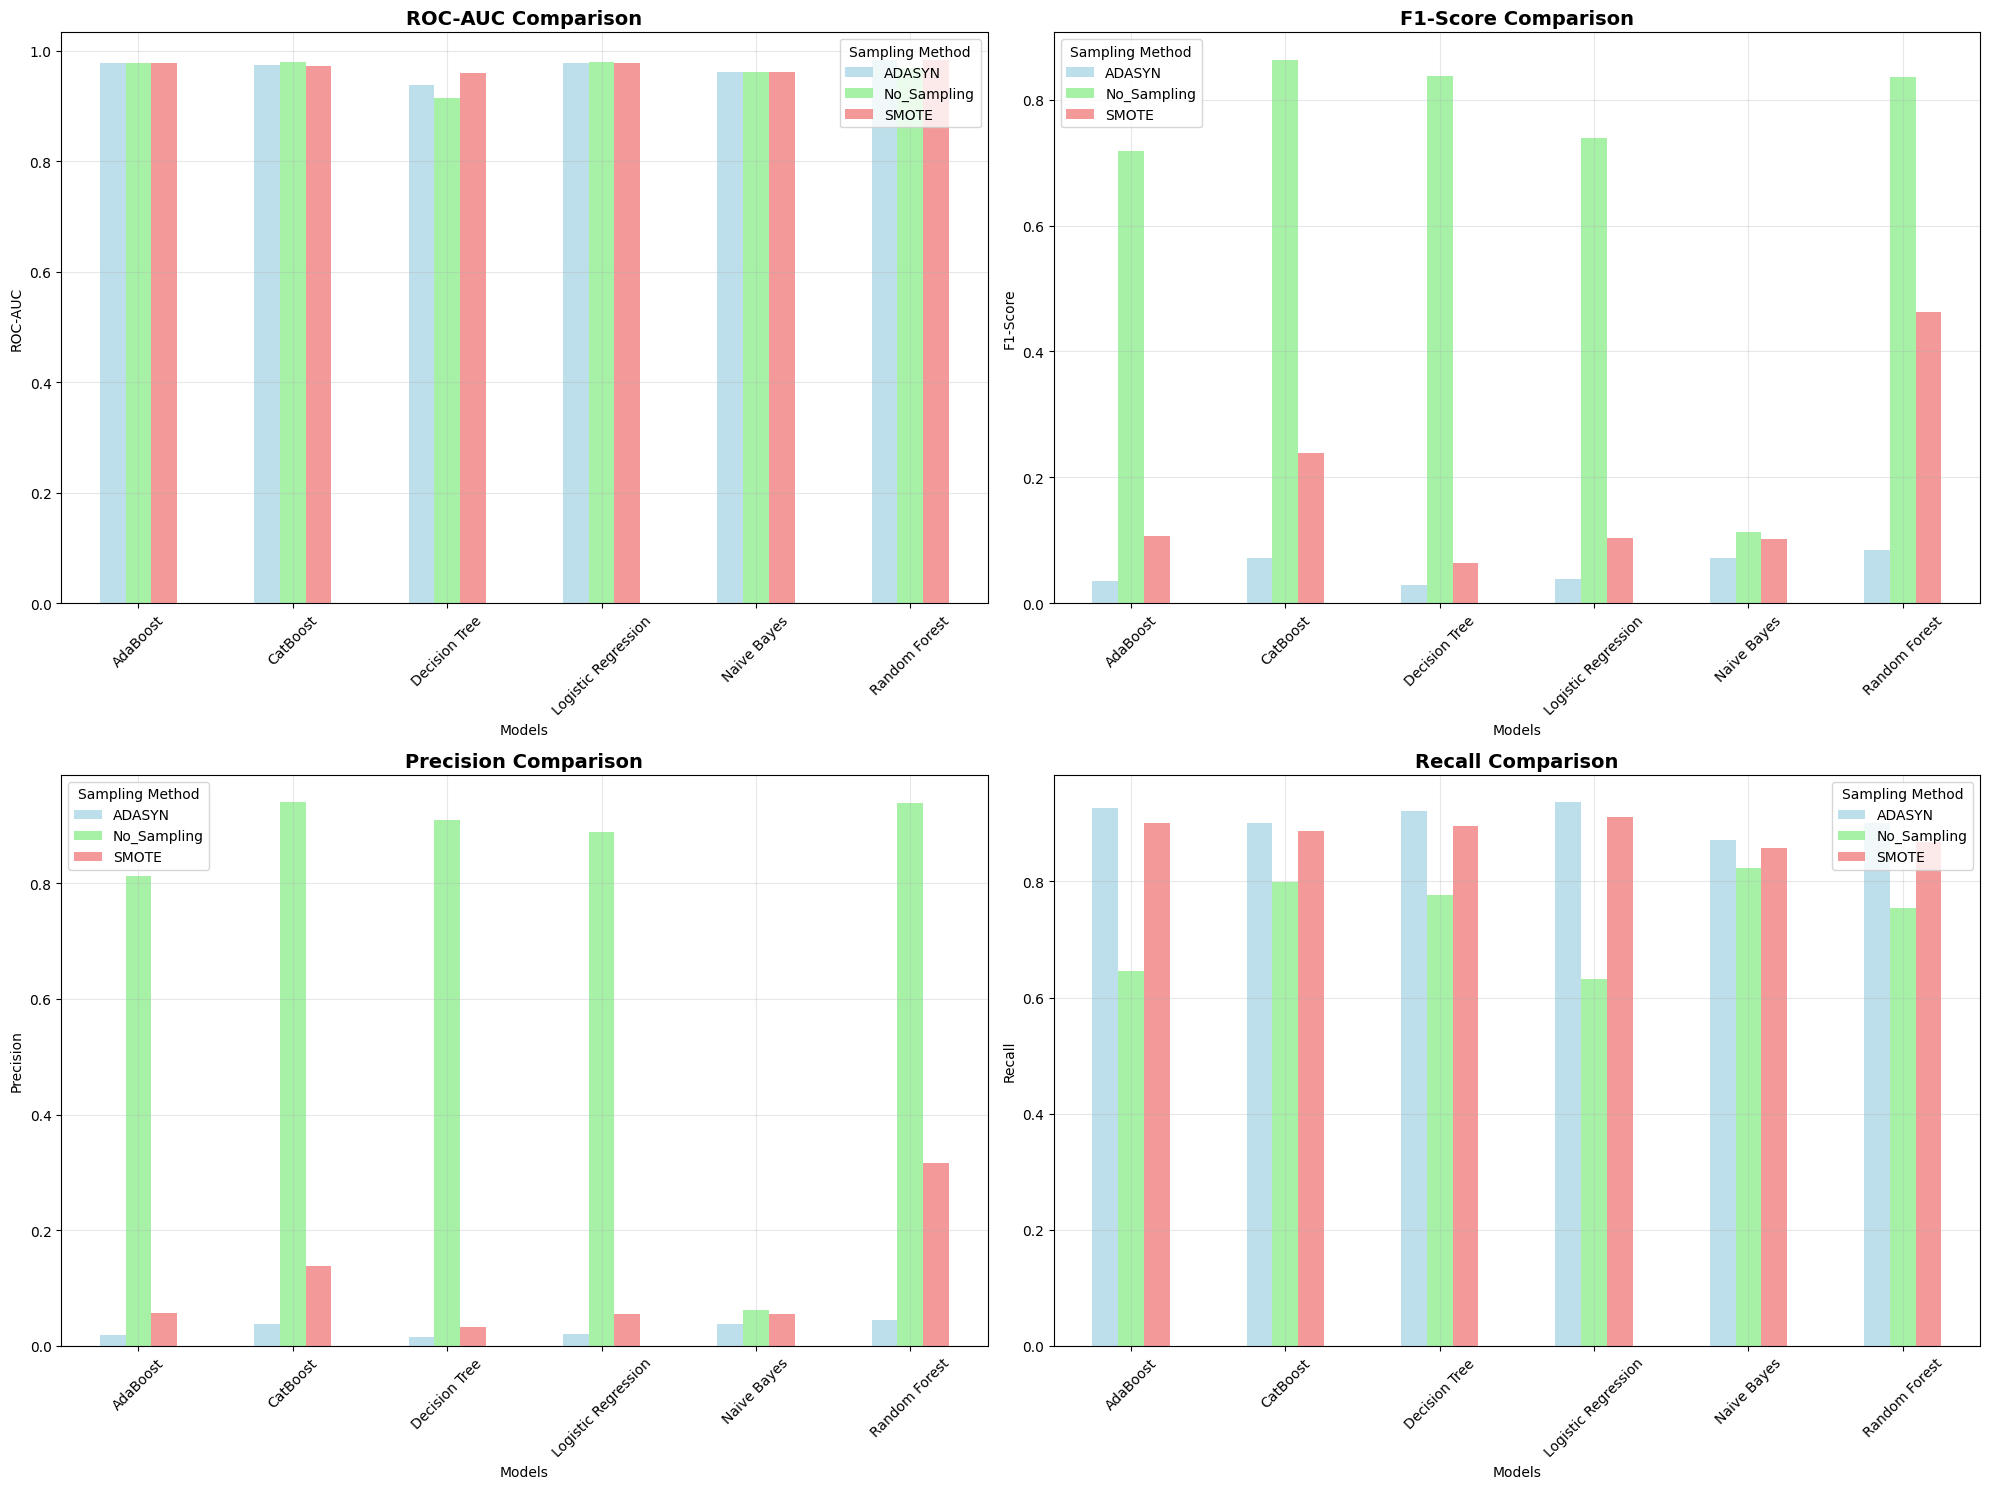


10. SAVING RESULTS
--------------------------------------------------
✓ Results saved to CSV files:
  - results_no_sampling.csv
  - results_smote.csv
  - results_adasyn.csv
  - comprehensive_results.csv

MODELING PIPELINE COMPLETED SUCCESSFULLY!


In [12]:
print("="*80)
print("CREDIT CARD FRAUD DETECTION - COMPLETE MODELING PIPELINE")
print("="*80)

# 1. DATA PREPR|OCESSING
print("\n1. DATA PREPROCESSING")
print("-" * 50)

# Separate features and target
X = df.drop('Class', axis=1)
y = df['Class']

print(f"Original dataset shape: {X.shape}")
print(f"Class distribution: {y.value_counts().to_dict()}")

# Identify skewed features (absolute skewness > 0.5)
skewed_features = []
for column in X.columns:
    skew_val = abs(stats.skew(X[column]))
    if skew_val > 0.5:
        skewed_features.append(column)

print(f"\nSkewed features identified: {len(skewed_features)}")
print(f"Features: {skewed_features}")

# Apply RobustScaler to all features
robust_scaler = RobustScaler()
X_scaled = robust_scaler.fit_transform(X)
X_scaled = pd.DataFrame(X_scaled, columns=X.columns)

# Apply Yeo-Johnson transformation to skewed features
yeo_johnson = PowerTransformer(method='yeo-johnson', standardize=False)
X_scaled[skewed_features] = yeo_johnson.fit_transform(X_scaled[skewed_features])

print("✓ RobustScaler applied to all features")
print("✓ Yeo-Johnson transformation applied to skewed features")

# 2. MODEL CONFIGURATIONS
print("\n2. MODEL CONFIGURATIONS")
print("-" * 50)

# Define models and their hyperparameter grids
models_config = {
    'Naive Bayes': {
        'model': GaussianNB(),
        'params': {
            'var_smoothing': [1e-9, 1e-8, 1e-7]
        }
    },
    'CatBoost': {
        'model': CatBoostClassifier(random_state=42, verbose=False),
        'params': {
            'iterations': [10, 50],
            'depth': [3, 5],
        }
    },
    'Logistic Regression': {
        'model': LogisticRegression(random_state=42, max_iter=500),
        'params': {
            'C': [0.1, 1, 10],
            'penalty': ['l2'],
            'solver': ['liblinear']
        }
    },
    'Decision Tree': {
        'model': DecisionTreeClassifier(random_state=42),
        'params': {
            'max_depth': [3, 5, 7],
            'min_samples_split': [5, 10],
        }
    },
    'Random Forest': {
        'model': RandomForestClassifier(random_state=42, n_jobs=-1),
        'params': {
            'n_estimators': [10, 50],
            'max_depth': [3, 5, 7],
        }
    },
    'AdaBoost': {
        'model': AdaBoostClassifier(random_state=42),
        'params': {
            'n_estimators': [10, 50],
            'learning_rate': [0.5, 1.0],
        }
    }
}

# 3. CROSS-VALIDATION SETUP
print("\n3. CROSS-VALIDATION SETUP")
print("-" * 50)

# Stratified K-Fold Cross Validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
print("✓ Using Stratified 5-Fold Cross Validation")

# 4. FUNCTION TO EVALUATE MODELS
def evaluate_model(model, X_data, y_data, cv_folds):
    """ Evaluate model using cross-validation and return metrics"""
    
    # ROC-AUC Score
    roc_auc_scores = cross_val_score(model, X_data, y_data, cv=cv_folds, scoring='roc_auc')
    
    # F1 Score
    f1_scores = cross_val_score(model, X_data, y_data, cv=cv_folds, scoring='f1')
    
    # Precision
    precision_scores = cross_val_score(model, X_data, y_data, cv=cv_folds, scoring='precision')
    
    # Recall
    recall_scores = cross_val_score(model, X_data, y_data, cv=cv_folds, scoring='recall')
    
    return {
        'ROC-AUC': roc_auc_scores.mean(),
        'F1-Score': f1_scores.mean(),
        'Precision': precision_scores.mean(),
        'Recall': recall_scores.mean(),
        'ROC-AUC_std': roc_auc_scores.std(),
        'F1-Score_std': f1_scores.std(),
        'Precision_std': precision_scores.std(),
        'Recall_std': recall_scores.std()
    }

# 5. MODELING WITHOUT OVERSAMPLING
print("\n4. MODELING WITHOUT OVERSAMPLING")
print("-" * 50)

results_no_sampling = []

for model_name, config in models_config.items():
    print(f"\nTraining {model_name}...")
    
    # Grid Search with Cross Validation
    grid_search = GridSearchCV(
        config['model'], 
        config['params'], 
        cv=cv, 
        scoring='roc_auc',
        n_jobs=-1,
        verbose=0
    )
    
    # Fit the model
    grid_search.fit(X_scaled, y)
    
    # Get best model
    best_model = grid_search.best_estimator_
    best_params = grid_search.best_params_
    
    # Evaluate the best model
    metrics = evaluate_model(best_model, X_scaled, y, cv)
    
    # Store results
    results_no_sampling.append({
        'Model': model_name,
        'Best_Config': str(best_params),
        'ROC-AUC': round(metrics['ROC-AUC'], 4),
        'F1-Score': round(metrics['F1-Score'], 4),
        'Precision': round(metrics['Precision'], 4),
        'Recall': round(metrics['Recall'], 4)
    })
    
    print(f"✓ {model_name} completed")
    print(f"  Best ROC-AUC: {metrics['ROC-AUC']:.4f}")

# Create results DataFrame
results_no_sampling_df = pd.DataFrame(results_no_sampling)
print("\n" + "="*100)
print("RESULTS WITHOUT OVERSAMPLING")
print("="*100)
print(results_no_sampling_df.to_string(index=False))

# 6. MODELING WITH SMOTE
print("\n\n5. MODELING WITH SMOTE")
print("-" * 50)

results_smote = []

for model_name, config in models_config.items():
    print(f"\nTraining {model_name} with SMOTE...")
    
    # Create pipeline with SMOTE
    pipeline = ImbPipeline([
        ('smote', SMOTE(random_state=42)),
        ('classifier', config['model'])
    ])
    
    # Create parameter grid for pipeline
    param_grid = {}
    for key, value in config['params'].items():
        param_grid[f'classifier__{key}'] = value
    
    # Grid Search with Cross Validation
    grid_search = GridSearchCV(
        pipeline, 
        param_grid, 
        cv=cv, 
        scoring='roc_auc',
        n_jobs=-1,
        verbose=0
    )
    
    # Fit the model
    grid_search.fit(X_scaled, y)
    
    # Get best model and parameters
    best_model = grid_search.best_estimator_
    best_params = {k.replace('classifier__', ''): v for k, v in grid_search.best_params_.items()}
    
    # Evaluate the best model
    metrics = evaluate_model(best_model, X_scaled, y, cv)
    
    # Store results
    results_smote.append({
        'Model': model_name,
        'Best_Config': str(best_params),
        'ROC-AUC': round(metrics['ROC-AUC'], 4),
        'F1-Score': round(metrics['F1-Score'], 4),
        'Precision': round(metrics['Precision'], 4),
        'Recall': round(metrics['Recall'], 4)
    })
    
    print(f"✓ {model_name} with SMOTE completed")
    print(f"  Best ROC-AUC: {metrics['ROC-AUC']:.4f}")

# Create results DataFrame
results_smote_df = pd.DataFrame(results_smote)
print("\n" + "="*100)
print("RESULTS WITH SMOTE")
print("="*100)
print(results_smote_df.to_string(index=False))

# 7. MODELING WITH ADASYN
print("\n\n6. MODELING WITH ADASYN")
print("-" * 50)

results_adasyn = []

for model_name, config in models_config.items():
    print(f"\nTraining {model_name} with ADASYN...")
    
    # Create pipeline with ADASYN
    pipeline = ImbPipeline([
        ('adasyn', ADASYN(random_state=42)),
        ('classifier', config['model'])
    ])
    
    # Create parameter grid for pipeline
    param_grid = {}
    for key, value in config['params'].items():
        param_grid[f'classifier__{key}'] = value
    
    # Grid Search with Cross Validation
    grid_search = GridSearchCV(
        pipeline, 
        param_grid, 
        cv=cv, 
        scoring='roc_auc',
        n_jobs=-1,
        verbose=0
    )
    
    # Fit the model
    grid_search.fit(X_scaled, y)
    
    # Get best model and parameters
    best_model = grid_search.best_estimator_
    best_params = {k.replace('classifier__', ''): v for k, v in grid_search.best_params_.items()}
    
    # Evaluate the best model
    metrics = evaluate_model(best_model, X_scaled, y, cv)
    
    # Store results
    results_adasyn.append({
        'Model': model_name,
        'Best_Config': str(best_params),
        'ROC-AUC': round(metrics['ROC-AUC'], 4),
        'F1-Score': round(metrics['F1-Score'], 4),
        'Precision': round(metrics['Precision'], 4),
        'Recall': round(metrics['Recall'], 4)
    })
    
    print(f"✓ {model_name} with ADASYN completed")
    print(f"  Best ROC-AUC: {metrics['ROC-AUC']:.4f}")

# Create results DataFrame
results_adasyn_df = pd.DataFrame(results_adasyn)
print("\n" + "="*100)
print("RESULTS WITH ADASYN")
print("="*100)
print(results_adasyn_df.to_string(index=False))

# 8. COMPREHENSIVE COMPARISON
print("\n\n7. COMPREHENSIVE COMPARISON")
print("-" * 50)

# Combine all results for comparison
all_results = []

# Add results without oversampling
for _, row in results_no_sampling_df.iterrows():
    all_results.append({
        'Sampling_Method': 'No_Sampling',
        'Model': row['Model'],
        'Best_Config': row['Best_Config'],
        'ROC-AUC': row['ROC-AUC'],
        'F1-Score': row['F1-Score'],
        'Precision': row['Precision'],
        'Recall': row['Recall']
    })

# Add SMOTE results
for _, row in results_smote_df.iterrows():
    all_results.append({
        'Sampling_Method': 'SMOTE',
        'Model': row['Model'],
        'Best_Config': row['Best_Config'],
        'ROC-AUC': row['ROC-AUC'],
        'F1-Score': row['F1-Score'],
        'Precision': row['Precision'],
        'Recall': row['Recall']
    })

# Add ADASYN results
for _, row in results_adasyn_df.iterrows():
    all_results.append({
        'Sampling_Method': 'ADASYN',
        'Model': row['Model'],
        'Best_Config': row['Best_Config'],
        'ROC-AUC': row['ROC-AUC'],
        'F1-Score': row['F1-Score'],
        'Precision': row['Precision'],
        'Recall': row['Recall']
    })

# Create comprehensive results DataFrame
comprehensive_results_df = pd.DataFrame(all_results)

print("\n" + "="*120)
print("COMPREHENSIVE RESULTS COMPARISON")
print("="*120)
print(comprehensive_results_df.to_string(index=False))

# 9. BEST PERFORMING MODELS
print("\n\n8. BEST PERFORMING MODELS")
print("-" * 50)

# Find best models for each metric
best_roc_auc = comprehensive_results_df.loc[comprehensive_results_df['ROC-AUC'].idxmax()]
best_f1 = comprehensive_results_df.loc[comprehensive_results_df['F1-Score'].idxmax()]
best_precision = comprehensive_results_df.loc[comprehensive_results_df['Precision'].idxmax()]
best_recall = comprehensive_results_df.loc[comprehensive_results_df['Recall'].idxmax()]

print("Best Models by Metric:")
print(f"• Best ROC-AUC: {best_roc_auc['Model']} with {best_roc_auc['Sampling_Method']} ({best_roc_auc['ROC-AUC']:.4f})")
print(f"• Best F1-Score: {best_f1['Model']} with {best_f1['Sampling_Method']} ({best_f1['F1-Score']:.4f})")
print(f"• Best Precision: {best_precision['Model']} with {best_precision['Sampling_Method']} ({best_precision['Precision']:.4f})")
print(f"• Best Recall: {best_recall['Model']} with {best_recall['Sampling_Method']} ({best_recall['Recall']:.4f})")

# 10. VISUALIZATION
print("\n\n9. RESULTS VISUALIZATION")
print("-" * 50)

# Create visualization comparing all methods
fig, axes = plt.subplots(2, 2, figsize=(20, 15))

metrics = ['ROC-AUC', 'F1-Score', 'Precision', 'Recall']
colors = ['lightblue', 'lightgreen', 'lightcoral']

for i, metric in enumerate(metrics):
    ax = axes[i//2, i%2]
    
    # Pivot data for plotting
    pivot_data = comprehensive_results_df.pivot(index='Model', columns='Sampling_Method', values=metric)
    
    # Create grouped bar plot
    pivot_data.plot(kind='bar', ax=ax, color=colors, alpha=0.8)
    ax.set_title(f'{metric} Comparison', fontsize=14, fontweight='bold')
    ax.set_ylabel(metric)
    ax.set_xlabel('Models')
    ax.legend(title='Sampling Method')
    ax.tick_params(axis='x', rotation=45)
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Save results to CSV files
print("\n10. SAVING RESULTS")
print("-" * 50)

results_no_sampling_df.to_csv('results_no_sampling.csv', index=False)
results_smote_df.to_csv('results_smote.csv', index=False)
results_adasyn_df.to_csv('results_adasyn.csv', index=False)
comprehensive_results_df.to_csv('comprehensive_results.csv', index=False)

print("✓ Results saved to CSV files:")
print("  - results_no_sampling.csv")
print("  - results_smote.csv") 
print("  - results_adasyn.csv")
print("  - comprehensive_results.csv")

print("\n" + "="*80)
print("MODELING PIPELINE COMPLETED SUCCESSFULLY!")
print("="*80)